In [ ]:
import pandas as pd
import numpy as np
import glob
import os

def load_trials(base_path):
    X, y = [], []
    labels = {'ADLs': 0, 'Falls': 1, 'Near_Falls': 2}
    
    for subject_path in glob.glob(os.path.join(base_path, 'sub*')):
        for label_name in ['ADLs', 'Falls', 'Near_Falls']:
            folder = os.path.join(subject_path, label_name)
            for file in glob.glob(os.path.join(folder, '*.xlsx')):
                df = pd.read_excel(file)

                # waist
                try:
                    acc_x = df['waist Acceleration X (m/s^2)']
                    acc_y = df['waist Acceleration Y (m/s^2)']
                    acc_z = df['waist Acceleration Z (m/s^2)']
                    df['acc_magnitude'] = np.sqrt(acc_x**2 + acc_y**2 + acc_z**2)
                except KeyError as e:
                    raise ValueError(f"Coluna esperada não encontrada no arquivo {file}: {e}")
                
                # 'Time' or 'vTime'
                time_col = 'Time' if 'Time' in df.columns else 'vTime'
                data = df.drop(columns=[time_col]).values

                X.append(data)
                y.append(labels[label_name])
    
    return X, y

X_raw, y = load_trials('/home/carlos/Pictures/texas/AI_ML_Challenge')

In [ ]:
from sklearn.preprocessing import StandardScaler

def sliding_windows(data, labels, window_size=100, stride=50):
    X_windows, y_windows = [], []
    for trial, label in zip(data, labels):
        for start in range(0, len(trial) - window_size, stride):
            segment = trial[start:start+window_size]
            X_windows.append(segment)
            y_windows.append(label)
    return np.array(X_windows), np.array(y_windows)

X_win, y_win = sliding_windows(X_raw, y, window_size=128, stride=64)

scaler = StandardScaler()
X_norm = X_win.reshape(-1, X_win.shape[-1])
X_norm = scaler.fit_transform(X_norm).reshape(X_win.shape)



In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

input_shape = X_norm.shape[1:]  # (timesteps, features)

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Conv1D(64, kernel_size=5, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(128, kernel_size=5, activation='relu'),
    layers.GlobalAveragePooling1D(),
    layers.Dense(64, activation='relu')  # Embedding
])

deep_features = model.predict(X_norm)

2025-04-16 18:28:31.521345: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-16 18:28:31.608681: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-16 18:28:36.674498: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2025-04-16 18:28:43.371728: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/t

450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


I chose to use a 1D CNN network to extract temporal patterns from the certification signals. This type of model is efficient in capturing local variations in time series with low computational cost. After extracting embeddings, I used a Random Forest for its robustness, ability to handle non-linearly separable data, and ease of interpretation. Using class_weight='balanced' helps to compensate for class imbalance.

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(deep_features, y_win, test_size=0.2, stratify=y_win, random_state=42)

clf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['ADL', 'Fall', 'Near Fall']))

              precision    recall  f1-score   support

         ADL       0.96      0.97      0.97      1208
        Fall       0.90      0.84      0.87       974
   Near Fall       0.80      0.86      0.83       696

    accuracy                           0.90      2878
   macro avg       0.89      0.89      0.89      2878
weighted avg       0.90      0.90      0.90      2878



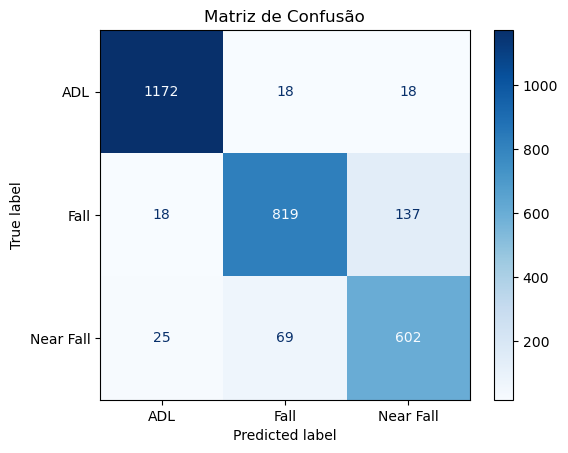

In [6]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['ADL', 'Fall', 'Near Fall'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusão")
plt.show()